## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

## Read CSV file with values for stimulation

In [2]:
filename=r'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20200220_blocking_fabs/202002_Analysis_silvio/values_for_plotting.csv'

In [3]:
df=pd.read_csv(filename,sep=',',header=None)

In [4]:
df

,0,1,2
0,Blkocked_plus12\Slice02_1,15.249039,12h
1,Blkocked_plus12\Slice02_2,12.818042,12h
2,Blkocked_plus12\Slice02_3,10.695575,12h
3,Blkocked_plus12\Slice03_1,17.736681,12h
4,Blkocked_plus12\Slice03_2,13.885086,12h
5,Blkocked_plus12\Slice03_3,15.020326,12h
6,Blkocked_plus12\Slice04_1,18.531327,12h
7,Blkocked_plus12\Slice04_2,26.231569,12h
8,Blkocked_plus12\Slice04_3,30.249450,12h
9,Blkocked_plus12\Slice05_1,21.271249,12h


In [6]:
df.columns=['filename','mean','Condition']

In [7]:
df["Condition"].unique()

array(['12h', '0h', 'bic', 'unblocked'], dtype=object)

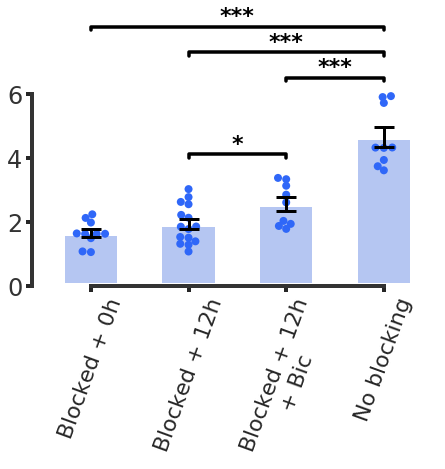

In [36]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker


order=['0h','12h','bic','unblocked']

fig=plt.figure(figsize=(7,5))
g=fig.gca()
sns.barplot(x="Condition",y="mean",data=df,
            color="#abc2fc",linewidth=6,order=order,ci=None)

sns.swarmplot(x="Condition",y="mean",data=df,
            order=order,color="#2F67F8",size=8)




def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        
        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
change_width(g, .6)        
plt.errorbar(x=[0,1,2,3],
             y=[df[df["Condition"]==cond]["mean"].mean() for cond in order],
             yerr=[df[df["Condition"]==cond]["mean"].sem() for cond in order],
             xerr=None,
             ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

#plt.legend(['New epitopes','All epitopes'],fontsize=24)


scale_x=10
ticks_y=ticker.FuncFormatter(lambda x, pos: '{0:g}' .format(x/scale_x))
g=plt.gca()
g.yaxis.set_major_formatter(ticks_y)

g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),["Blocked + 0h","Blocked + 12h","Blocked + 12h\n+ Bic","No blocking"],
           size=22,rotation=70)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)

x1, x2 = 0,3
y= 80
h=1.1
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=22, weight='bold')

x1, x2 = 1,3
y= 72
h=1.1
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=22, weight='bold')

x1, x2 = 2,3
y= 64
h=1.1
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=22, weight='bold')

x1, x2 = 1,2
y= 40
h=1.1
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=22, weight='bold')





diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'13_organotypic_slices_fabs.svg', bbox_inches='tight', format='svg')

In [38]:
for cond in df["Condition"].unique():
    print(cond+'. ' +str(len(df[df["Condition"]==cond])))

12h. 15
0h. 10
bic. 9
unblocked. 9


## anova

In [40]:
dfmeans=df

In [41]:
var="mean"
bgauto=dfmeans[dfmeans["Condition"]=="12h"][var].dropna().values
bgatto=dfmeans[dfmeans["Condition"]=="0h"][var].dropna().values
bgblockplus0=dfmeans[dfmeans["Condition"]=="bic"][var].dropna().values
bgblockplus12=dfmeans[dfmeans["Condition"]=="unblocked"][var].dropna().values

stats.f_oneway(bgauto, bgatto, bgblockplus0,bgblockplus12)

F_onewayResult(statistic=40.859219326833895, pvalue=4.086545818174722e-12)

In [42]:
import ipywidgets as widgets
from ipywidgets import interact
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
from statsmodels.stats.libqsturng import psturng

x = dfmeans["Condition"]
y = dfmeans[var]
# DataFrame.
mcDate = multi.MultiComparison(y,x)
Results = mcDate.tukeyhsd()
df = pd.DataFrame(data=Results._results_table.data[1:], columns=Results._results_table.data[0])
res=Results
pvals=psturng(np.abs(res.meandiffs / res.std_pairs),len(res.groupsunique), res.df_total)
df["pvals"]=pvals

df

,group1,group2,meandiff,lower,upper,reject,pvals
0,0h,12h,2.7931,-4.4555,10.0417,False,0.708548
1,0h,bic,9.0033,0.8453,17.1614,True,0.025629
2,0h,unblocked,30.0270,21.8690,38.1850,True,0.001000
3,12h,bic,6.2102,-1.2761,13.6965,False,0.133968
4,12h,unblocked,27.2339,19.7475,34.7202,True,0.001000
5,bic,unblocked,21.0237,12.6537,29.3936,True,0.001000
